## Preprocessing

In [2]:
# Import our dependencies
import pandas as pd 
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.metrics import accuracy_score
import tensorflow as tf
import keras_tuner as kt
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt


In [3]:
#  Import and read the charity_data.csv.
application_df = pd.read_csv("https://static.bc-edx.com/data/dl-1-2/m21/lms/starter/charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [4]:
# Pull the the count of instances that a name appears in the dataset to a column
# Group by the 'NAME' column and count the occurrences
name_counts = application_df.groupby('NAME').size().reset_index(name='NAME_COUNT')

# Merge the counts back into the original DataFrame
application_df = pd.merge(application_df, name_counts, on='NAME', how='left')

In [5]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df.drop(['EIN', 'NAME'], axis=1, inplace=True)

In [6]:
# Mapping the INCOME_AMT comlumn to better capture the ordinality

# Create a mapping dictionary
income_mapping = {
    '0': 0,                       # No income
    '1-9999': 1,                  # Very low income
    '10000-24999': 2,             # Low income
    '25000-99999': 3,             # Moderate income
    '100000-499999': 4,           # High income
    '1M-5M': 5,                   # Very high income
    '5M-10M': 6,                  # Extremely high income
    '10M-50M': 7,                 # Exceptionally high income
    '50M+': 8                     # Extraordinarily high income
}

# Map the 'INCOME_AMT' column using the mapping dictionary
application_df['INCOME_AMT'] = application_df['INCOME_AMT'].map(income_mapping)

In [7]:
# Determine the number of unique values in each column.
application_df.nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
NAME_COUNT                  92
dtype: int64

In [8]:
# Look at APPLICATION_TYPE value counts for binning
application_df.APPLICATION_TYPE.value_counts()

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

In [9]:
# Choose a cutoff value and create a list of application types to be replaced
cutoff_threshold = 25

# Identify application types to be replaced
application_types_to_replace = application_df['APPLICATION_TYPE'].value_counts()[application_df['APPLICATION_TYPE'].value_counts() < cutoff_threshold].index

# Replace the less frequent application types with 'Other'
application_df.loc[application_df['APPLICATION_TYPE'].isin(application_types_to_replace), 'APPLICATION_TYPE'] = 'Other'

# Check the value counts after binning
application_df['APPLICATION_TYPE'].value_counts()


T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
T9         156
T13         66
Other       27
T12         27
Name: APPLICATION_TYPE, dtype: int64

In [10]:
# Look at CLASSIFICATION value counts for binning
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C4120        1
C8210        1
C2561        1
C4500        1
C2150        1
Name: CLASSIFICATION, Length: 71, dtype: int64

In [11]:
# Choose a cutoff value and create a list of classifications to be replaced
cutoff_threshold = 50

# Identify classifications  to be replaced
classifications_to_replace = application_df['CLASSIFICATION'].value_counts()[application_df['CLASSIFICATION'].value_counts() < cutoff_threshold].index

# Replace in dataframe
for cls in classifications_to_replace:
    application_df['CLASSIFICATION'] = application_df['CLASSIFICATION'].replace(cls,"Other")
    
# Check to make sure binning was successful
application_df['CLASSIFICATION'].value_counts()

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
C7000      777
Other      391
C1700      287
C4000      194
C5000      116
C1270      114
C2700      104
C2800       95
C7100       75
C1300       58
C1280       50
Name: CLASSIFICATION, dtype: int64

In [12]:
# Drop status as it only has five instances of 0
application_df.drop('STATUS', axis=1, inplace=True)

In [13]:
# Change some data types
application_df['INCOME_AMT'] = application_df['INCOME_AMT'].astype('category')
application_df['IS_SUCCESSFUL']= application_df['IS_SUCCESSFUL'].astype('category')


In [14]:
application_df.dtypes

APPLICATION_TYPE            object
AFFILIATION                 object
CLASSIFICATION              object
USE_CASE                    object
ORGANIZATION                object
INCOME_AMT                category
SPECIAL_CONSIDERATIONS      object
ASK_AMT                      int64
IS_SUCCESSFUL             category
NAME_COUNT                   int64
dtype: object

In [15]:
# Convert categorical data to numeric with `pd.get_dummies`
columns_to_encode = ['APPLICATION_TYPE','AFFILIATION','CLASSIFICATION','USE_CASE','ORGANIZATION','SPECIAL_CONSIDERATIONS']

# get_dummies one-hot encoding
encoded_df = pd.get_dummies(application_df, columns=columns_to_encode)


In [16]:
# Split our preprocessed data into our features and target arrays
X = encoded_df.drop('IS_SUCCESSFUL', axis=1)
y = encoded_df['IS_SUCCESSFUL']

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=93, stratify=y)

In [17]:

# Scale ASK_AMT feature on X_train
ask_skewness = X_train['ASK_AMT'].skew()
ask_kurtosis = X_train['ASK_AMT'].kurtosis()

if abs(ask_skewness) > 1 and abs(ask_kurtosis) > 1:
    ask_scaler = PowerTransformer()  # Apply PowerTransformer for highly skewed and high kurtosis data
else:
    ask_scaler = MinMaxScaler()  # Apply MinMaxScaler for other cases

# Fit and transform ASK_AMT on X_train
X_train['ASK_AMT'] = ask_scaler.fit_transform(X_train[['ASK_AMT']])

# Transform ASK_AMT on X_test (no fitting)
X_test['ASK_AMT'] = ask_scaler.transform(X_test[['ASK_AMT']])

# Scale NAME_COUNT feature on X_train
name_count_skewness = X_train['NAME_COUNT'].skew()
name_count_kurtosis = X_train['NAME_COUNT'].kurtosis()

if abs(name_count_skewness) > 1 and abs(name_count_kurtosis) > 1:
    name_count_scaler = PowerTransformer()  # Apply PowerTransformer for highly skewed and high kurtosis data
else:
    name_count_scaler = StandardScaler()  # Apply StandardScaler for other cases

# Fit and transform 'NAME_COUNT' on X_train
X_train['NAME_COUNT'] = name_count_scaler.fit_transform(X_train[['NAME_COUNT']])

# Transform 'NAME_COUNT' on X_test (no fitting)
X_test['NAME_COUNT'] = name_count_scaler.transform(X_test[['NAME_COUNT']])


In [18]:
# are the X_train and X_test columns the same? 
if set(X_train.columns) == set(X_test.columns):
  print("X_train and X_test have the same columns")
else:
  print("X_train and X_test do not have the same columns")

X_train and X_test have the same columns


In [19]:
X_train.head()

,INCOME_AMT,ASK_AMT,NAME_COUNT,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T12,APPLICATION_TYPE_T13,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,...,USE_CASE_Heathcare,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
10523,0,-0.573777,1.197718,0,0,0,0,0,1,0,...,0,0,1,0,1,0,0,0,1,0
30415,3,1.429615,1.439494,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,1,0
24195,5,1.971568,-0.845853,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,1,0
1308,3,1.744351,-0.845853,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,1,0
5028,0,-0.573777,-0.845853,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,1,0


In [20]:
X_test.head()

,INCOME_AMT,ASK_AMT,NAME_COUNT,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T12,APPLICATION_TYPE_T13,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,...,USE_CASE_Heathcare,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
25807,4,1.884104,-0.845853,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,1,0
28207,0,-0.573777,-0.845853,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,1,0
26881,4,1.802425,-0.845853,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,1,0
31075,0,-0.573777,0.323900,0,0,0,0,0,1,0,...,0,0,1,0,1,0,0,0,1,0
29404,3,1.910387,-0.845853,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,1,0


In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((25724, 48), (8575, 48), (25724,), (8575,))

## Compile, Train and Evaluate the Model

In [22]:

# Define the model-building function for the tuner
def build_model_1(hp):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(48,)))

    # Determine the number of layers
    num_layers = hp.Int('num_layers', min_value=1, max_value=4, default=1)

    # Add hidden layers
    for i in range(num_layers):
        # Determine the number of nodes for each layer
        num_nodes = hp.Int(f'layer_{i}_nodes', min_value=100, max_value=1000, step=100)
        model.add(keras.layers.Dense(units=num_nodes, activation='relu'))

    # Add the output layer
    model.add(keras.layers.Dense(units=1, activation='sigmoid'))

    # Determine the activation function
    activation = hp.Choice('activation', ['relu', 'sigmoid', 'tanh'])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Define the tuner
tuner = kt.Hyperband(
    build_model_1,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='keras_tuner_dir',
    project_name='neural_network',
    overwrite = True
)

# Perform the hyperparameter search
tuner.search(x=X_train, y=y_train, epochs=10, validation_data=(X_test, y_test))

# Get the best model hyperparameters
best_model_1 = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

best_model_1.summary()

Trial 30 Complete [00h 01m 23s]
val_accuracy: 0.7591836452484131

Best val_accuracy So Far: 0.7637317776679993
Total elapsed time: 00h 23m 16s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 800)               39200     
                                                                 
 dense_1 (Dense)             (None, 100)               80100     
                                                                 
 dense_2 (Dense)             (None, 700)               70700     
                                                                 
 dense_3 (Dense)             (None, 1)                 701       
                                                                 
Total params: 190,701
Trainable params: 190,701
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Compile the best model
best_model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
# Evaluate the best model on the test set
test_loss, test_accuracy = best_model_1.evaluate(X_test, y_test)

# Print the test accuracy and loss
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

268/268 [==============================] - 1s 2ms/step - loss: 0.4900 - accuracy: 0.7637
Test Accuracy: 0.7637317776679993
Test Loss: 0.4900406002998352


In [25]:
# Export our model to HDF5 file
# Save the best model to an H5 file
best_model_1.save('best_model.h5')

268/268 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


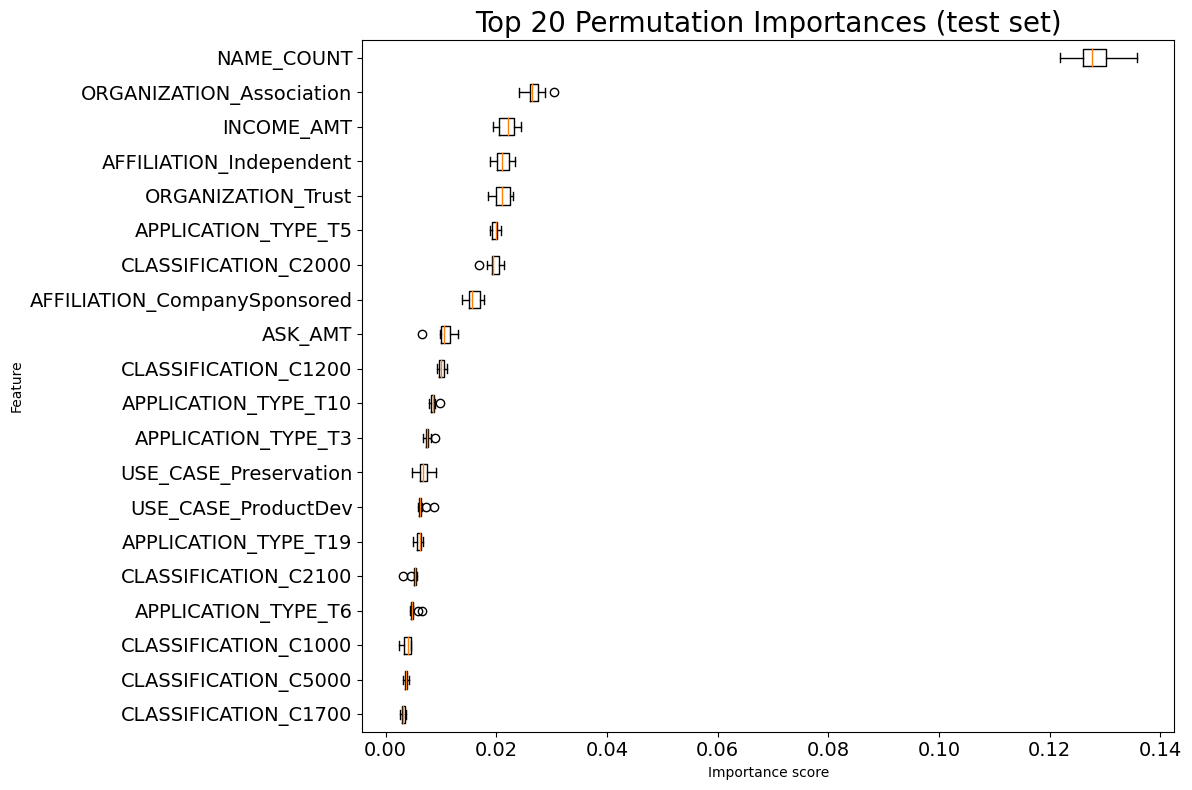

In [27]:
# Look at what features where important to the model using permutation importance

# Create a callable scoring function
def accuracy_scorer(estimator, X, y):
    y_pred = np.round(estimator.predict(X))
    return accuracy_score(y, y_pred)

# Compute permutation importance
result = permutation_importance(best_model_1, X_test, y_test, scoring=accuracy_scorer, n_repeats=10, random_state=0, n_jobs=-1)

# Sort features by importance
sorted_idx = result.importances_mean.argsort()

# Get the top 20 features
top_k = 20
top_k_idx = sorted_idx[-top_k:]  

# Set up the figure and axis with a larger size
fig, ax = plt.subplots(figsize=(12, 8))

# box plot
ax.boxplot(result.importances[top_k_idx].T,
           vert=False, labels=X_test.columns[top_k_idx])

# Increase the size of the labels for better readability
ax.set_title("Top 20 Permutation Importances (test set)", fontsize=20)
plt.ylabel("Feature")
plt.xlabel("Importance score")
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

# Ensure the layout is tight
fig.tight_layout()

# Show the plot
plt.show()
